In [16]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix
)

In [36]:
# Pull in receiving data
df = pd.read_csv('data/grower-pool-scores-v3.csv')
df.head()

,datereceived,cropyear,quantity,qccount,blockid,organic,commodity,variety,growerfamousid,growerid,...,avg_temp,avg_weight,avg_starch,avg_pressure,avg_split,avg_watercore,avg_frozen,avg_tiacidity,avg_lightexposure,pool
0,2013-08-14 12:06:04.000,2013,6,5.0,14-GA-1,N,Apple,Gala,14,1,...,0.0,205.200000,2.420000,19.350000,0.0,0.0,0.0,0.0,0.0,REG
1,2013-08-14 15:26:35.000,2013,52,NaN,14-GA-1,N,Apple,Gala,14,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REG
2,2013-08-14 15:27:09.000,2013,52,NaN,14-GA-1,N,Apple,Gala,14,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REG
3,2013-08-13 00:00:00.000,2013,52,9.0,14-GA-1,N,Apple,Gala,14,1,...,0.0,197.777777,3.088888,19.388888,0.0,0.0,0.0,0.0,0.0,REG
4,2013-08-13 00:00:00.000,2013,55,NaN,14-GA-1,N,Apple,Gala,14,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REG


### Clean Up Data

In [18]:
# Loop through the columns and check for null values
for column in df.columns:
    null_count = df[column].isnull().sum()
    if null_count > 0:
        print(f"Column '{column}' has {null_count} null values.")

Column 'qccount' has 7299 null values.
Column 'storagetype' has 8520 null values.
Column 'avg_size' has 7293 null values.
Column 'avg_temp' has 7293 null values.
Column 'avg_weight' has 7293 null values.
Column 'avg_starch' has 7293 null values.
Column 'avg_pressure' has 7293 null values.
Column 'avg_split' has 7293 null values.
Column 'avg_watercore' has 7293 null values.
Column 'avg_frozen' has 7293 null values.
Column 'avg_tiacidity' has 7293 null values.
Column 'avg_lightexposure' has 7293 null values.


In [19]:
# Fill in qccount with average of the column if null
df['qccount'] = df['qccount'].fillna(df['qccount'].mean())

In [20]:
# Drop storagetype
df = df.drop(columns=['storagetype'])

In [21]:
# Update avg_size, avg_temp, avg_weight, avg_starch, avg_pressure, avg_split, avg_watercore, avg_frozen, avg_tiacidity, and avg_lightexposure with averages of the same pool
df['avg_size'] = df.groupby('pool')['avg_size'].transform(lambda x: x.fillna(x.mean()))
df['avg_temp'] = df.groupby('pool')['avg_temp'].transform(lambda x: x.fillna(x.mean()))
df['avg_weight'] = df.groupby('pool')['avg_weight'].transform(lambda x: x.fillna(x.mean()))
df['avg_starch'] = df.groupby('pool')['avg_starch'].transform(lambda x: x.fillna(x.mean()))
df['avg_pressure'] = df.groupby('pool')['avg_pressure'].transform(lambda x: x.fillna(x.mean()))
df['avg_split'] = df.groupby('pool')['avg_split'].transform(lambda x: x.fillna(x.mean()))
df['avg_watercore'] = df.groupby('pool')['avg_watercore'].transform(lambda x: x.fillna(x.mean()))
df['avg_frozen'] = df.groupby('pool')['avg_frozen'].transform(lambda x: x.fillna(x.mean()))
df['avg_tiacidity'] = df.groupby('pool')['avg_tiacidity'].transform(lambda x: x.fillna(x.mean()))
df['avg_lightexposure'] = df.groupby('pool')['avg_lightexposure'].transform(lambda x: x.fillna(x.mean()))

In [22]:
# Update pool scores for normalization
# If pool is 13GACL3 assign it to LATE
df.loc[df['pool'] == '13GACL3', 'pool'] = 'LATE'
df.loc[df['pool'] == '13GALC3', 'pool'] = 'LATE'
df.loc[df['pool'] == '13GDCL3', 'pool'] = 'LATE'
df.loc[df['pool'] == '17RDOAC1', 'pool'] = 'MID'
df.loc[df['pool'] == '19OPLC', 'pool'] = 'MID'
df.loc[df['pool'] == 'CE1', 'pool'] = 'EARLY'
df.loc[df['pool'] == 'OCE1', 'pool'] = 'EARLY'
df.loc[df['pool'] == 'AE2', 'pool'] = 'EARLY'
df.loc[df['pool'] == 'OCEA1', 'pool'] = 'EARLY'
df.loc[df['pool'] == 'R3', 'pool'] = 'REG'

# Drop records with this pool
df = df[~df['pool'].isin(['19FJCSTDM', '19OFJCSTDM', 'OCA'])]


In [23]:
# Check the percentages of REG, EARLY, MID, and LATE
percentages = df['pool'].value_counts(normalize=True) * 100
print(percentages)

pool
REG      31.074897
LATE     26.067719
MID      22.511188
EARLY    20.346196
Name: proportion, dtype: float64


## Business Objective
The purpose of this work is to properly qualify the bins of fruit to either REG, EARLY, MID, OR LATE. This will allow us to minimize the impact of having culls that are related to keeping the fruit in a CA room for too long.

#### Encode the columns

In [24]:
def encode(df):
    # Encode the target column 'y'
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['pool'])
    X = df.drop(columns=['pool'], axis=1)

    # Encode all categorical columns
    categorical_columns = X.select_dtypes(include=['object']).columns
    numerical_columns = X.select_dtypes(include=['number']).columns

    # Encode categorical columns
    X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

    # Encode numerical columns
    scaler = StandardScaler()
    X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
    return X, y

X, y = encode(df)

In [49]:
##### Trim down X due to time constraints
# Add in all avg columns plus variety columns
X_trimmed = X[['cropyear', 'growerid', 'avg_size', 'avg_temp', 'avg_weight', 'avg_starch', 'avg_pressure', 'avg_split', 'avg_watercore', 'avg_frozen', 'avg_tiacidity', 'avg_lightexposure']]

# Add in all variety columns
variety_columns = [col for col in X.columns if 'variety_' in col]
X_trimmed = pd.concat([X_trimmed, X[variety_columns]], axis=1)


#### Split Test Data

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X_trimmed, y, test_size=0.3, random_state=42
)

### Set Up Baseline Model

In [51]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
baseline_acc = accuracy_score(y_test, dummy_pred)

print(f"Baseline Accuracy: {baseline_acc:.4f}")

Baseline Accuracy: 0.3100


#### Go through key models

In [61]:
start_time = time.time()
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_train_time = time.time() - start_time
print(f"Training time: {lr_train_time:.4f} seconds")

lr_pred = lr.predict(X_test)
lr_acc_test = accuracy_score(y_test, lr_pred)
lr_acc_train = accuracy_score(y_train, lr.predict(X_train))
print(f"Logistic Regression Accuracy: {lr_acc_test:.4f}")
print(f"Logistic Regression Accuracy (train): {lr_acc_train:.4f}")

lr_precision_score = precision_score(y_test, lr_pred, average='weighted')
print("Precision Score: ", lr_precision_score)

lr_recall_score = recall_score(y_test, lr_pred, average='weighted')
print("Recall Score: ", lr_recall_score)

Training time: 0.6306 seconds
Logistic Regression Accuracy: 0.4464
Logistic Regression Accuracy (train): 0.4456
Precision Score:  0.4293115927875832
Recall Score:  0.44643962848297214


/Users/ethan.florygilbertfruit.com/Documents/Repos/Berkely_Capstone/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [53]:
start_time = time.time()
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_train_time = time.time() - start_time
print(f"Training time: {knn_train_time:.4f} seconds")

knn_pred = knn.predict(X_test)
knn_acc_test = accuracy_score(y_test, knn_pred)
knn_acc_train = accuracy_score(y_train, knn.predict(X_train))
print(f"KNN Accuracy: {knn_acc_test:.4f}")
print(f"KNN Accuracy (train): {knn_acc_train:.4f}")

Training time: 0.0091 seconds
KNN Accuracy: 0.6433
KNN Accuracy (train): 0.7502


In [54]:
start_time = time.time()
svc = SVC()
svc.fit(X_train, y_train)
svc_train_time = time.time() - start_time
print(f"Training time: {svc_train_time:.4f} seconds")

svc_pred = svc.predict(X_test)
svc_acc_test = accuracy_score(y_test, svc_pred)
svc_acc_train = accuracy_score(y_train, svc.predict(X_train))
print(f"SVC Accuracy: {svc_acc_test:.4f}")
print(f"SVC Accuracy (train): {svc_acc_train:.4f}")

Training time: 47.2924 seconds
SVC Accuracy: 0.5713
SVC Accuracy (train): 0.5731


In [55]:
start_time = time.time()
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_train_time = time.time() - start_time
print(f"Training time: {dt_train_time:.4f} seconds")

dt_pred = dt.predict(X_test)
dt_acc_test = accuracy_score(y_test, dt_pred)
dt_acc_train = accuracy_score(y_train, dt.predict(X_train))
print(f"Decision Tree Accuracy: {dt_acc_test:.4f}")
print(f"Decision Tree Accuracy (train): {dt_acc_train:.4f}")

Training time: 0.1962 seconds
Decision Tree Accuracy: 0.6481
Decision Tree Accuracy (train): 0.9945


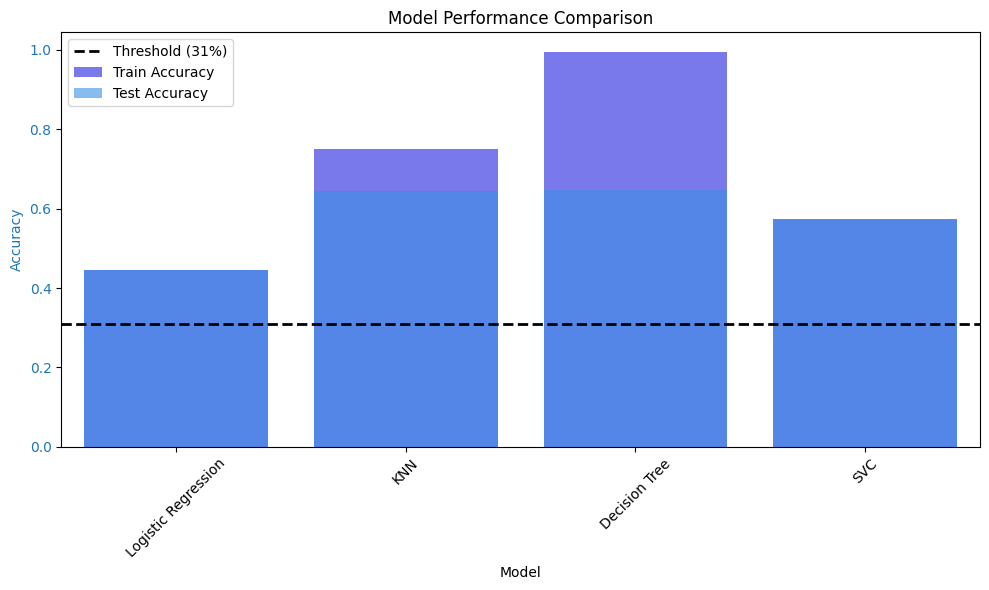

<Figure size 640x480 with 0 Axes>

In [56]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "KNN", "Decision Tree", "SVC"],
    "Train Time (s)": [lr_train_time, knn_train_time, dt_train_time, svc_train_time],
    "Train Accuracy": [lr_acc_train, knn_acc_train, dt_acc_train, svc_acc_train],
    "Test Accuracy": [lr_acc_test, knn_acc_test, dt_acc_test, svc_acc_test]
})

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Accuracy (Train & Test) on left y-axis
ax1.set_title("Model Performance Comparison")
ax1.set_xlabel("Model")
ax1.set_ylabel("Accuracy", color="tab:blue")
sns.barplot(data=results, x="Model", y="Train Accuracy", color="blue", alpha=0.6, label="Train Accuracy", ax=ax1)
sns.barplot(data=results, x="Model", y="Test Accuracy", color="dodgerblue", alpha=0.6, label="Test Accuracy", ax=ax1)
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Add threshold line for accuracy at 88.76%
ax1.axhline(y=31 / 100, color="black", linestyle="--", linewidth=2, label="Threshold (31%)")

# # Create second y-axis for Train Time
# ax2 = ax1.twinx()
# ax2.set_ylabel("Train Time (s)", color="tab:red")
# sns.barplot(data=results, x="Model", y="Train Time (s)", color="red", alpha=0.6, label="Train Time", ax=ax2)
# ax2.tick_params(axis="y", labelcolor="tab:red")

# Legends
ax1.legend(loc="upper left")
# ax2.legend(loc="upper right")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('./images/initial_model_performance_comparison.png')

#### Use enhancing techniques on the models

In [59]:
# Go through the different models of SVC
params = { 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
svc = SVC()
grid_search = GridSearchCV(estimator=svc, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
svc_precision_score = precision_score(y_test, grid_search.predict(X_test), average='weighted')
print("Precision Score: ", svc_precision_score)
svc_recall_score = recall_score(y_test, grid_search.predict(X_test), average='weighted')
print("Recall Score: ", svc_recall_score)

{'kernel': 'rbf'}
0.5625331724969843
Precision Score:  0.5697374091216195
Recall Score:  0.5712918660287082


In [57]:
params = { 'max_depth': [2, 5, 10, 15, 20]}
dt = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=dt, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

dt_precision_score = precision_score(y_test, grid_search.predict(X_test), average='weighted')
print("Precision Score: ", dt_precision_score)
dt_recall_score = recall_score(y_test, grid_search.predict(X_test), average='weighted')
print("Recall Score: ", dt_recall_score)

{'max_depth': 20}
0.6364776839565742
Precision Score:  0.6619784831725202
Recall Score:  0.6616943428088939


In [58]:
params = {'n_neighbors': [2, 5, 10, 12, 15]}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

knn_precision_score = precision_score(y_test, grid_search.predict(X_test), average='weighted')
print("Precision Score: ", knn_precision_score)
knn_recall_score = recall_score(y_test, grid_search.predict(X_test), average='weighted')
print("Recall Score: ", knn_recall_score)

{'n_neighbors': 5}
0.629601930036188
Precision Score:  0.6506236688095313
Recall Score:  0.643343653250774


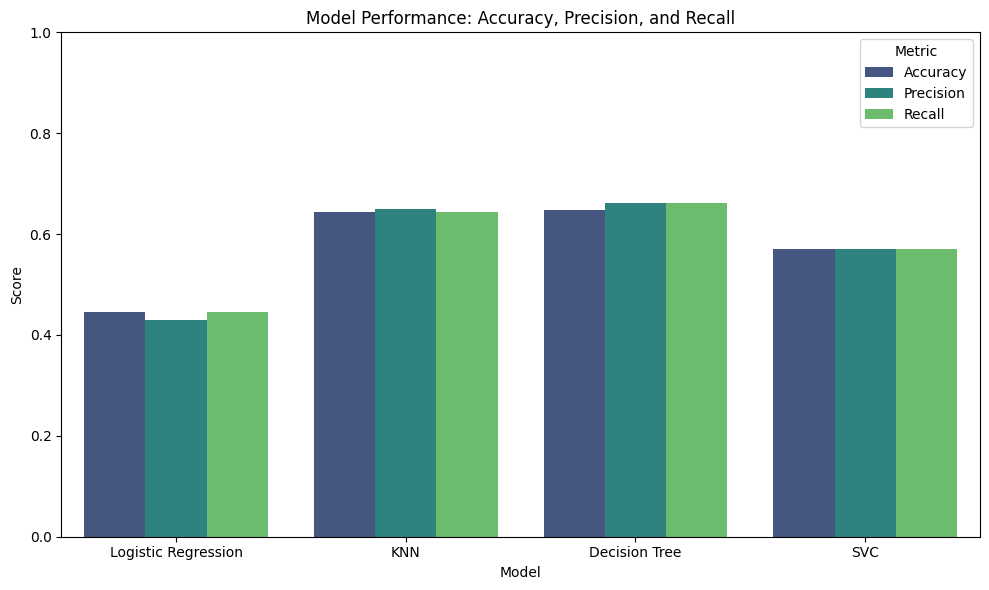

<Figure size 640x480 with 0 Axes>

In [62]:
stacked_data = pd.DataFrame({
    "Model": ["Logistic Regression", "KNN", "Decision Tree", "SVC"],
    "Accuracy": [lr_acc_test, knn_acc_test, dt_acc_test, svc_acc_test],
    "Precision": [lr_precision_score, knn_precision_score, dt_precision_score, svc_precision_score],
    "Recall": [lr_recall_score, knn_recall_score, dt_recall_score, svc_recall_score]
})

# Melt the data for easier plotting
stacked_data_melted = stacked_data.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Create the stacked bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=stacked_data_melted, x="Model", y="Score", hue="Metric", palette="viridis")

# Add labels and title
plt.title("Model Performance: Accuracy, Precision, and Recall")
plt.ylabel("Score")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.legend(title="Metric", loc="upper right")
plt.tight_layout()

# Show the plot
plt.show()
plt.savefig('./images/results.png')